In [64]:
using Ai4EComponentLib
using Ai4EComponentLib.CompressedAirSystem
using ModelingToolkit, DifferentialEquations
using Plots
using CoolProp

In [65]:
n0 = 4000
h_polCoff = [-91.7802, 1058.2670, 3213.1520]
etaCoff = [-0.0181, 0.2880, -0.2557]
surgeCoff = [-2.950e-7, 4.8009, -5.1678]
chokeCoff = [1.1054e-6, 8.6274, 20.7626]

3-element Vector{Float64}:
  1.1054e-6
  8.6274
 20.7626

In [66]:
f=0.05                  # Friction resistance coefficient
n = 15                  # Number of nodes
D = 0.4                 # Pipe diameter
L = 20                  # length
R = 3000                # Resistance coefficient
T = 300                 # Temperature
qm0 = 10 * ones(n)      # Initial mass flow rate
p0 = 10e5 * ones(n)     # initial pressure

15-element Vector{Float64}:
 1.0e6
 1.0e6
 1.0e6
 1.0e6
 1.0e6
 1.0e6
 1.0e6
 1.0e6
 1.0e6
 1.0e6
 1.0e6
 1.0e6
 1.0e6
 1.0e6
 1.0e6

In [67]:
n2 = 40                 # Number of nodes
D2 = 0.4                # Pipe diameter
L2 = 200                # length
R2 = 3000               # Resistance coefficient
T2 = 300                # Temperature
qm02 = 10 * ones(n2)    # Initial mass flow rate
p02 = range(10e5,8e5,length=n2)  #initial pressure

1.0e6:-5128.205128205128:800000.0

In [68]:
inletBoundary = Dict(
    "p" => 1.0e5,
    "T" => 300,
)

outletBoundary = Dict(
    "T" => 300,
    "p" => 4e5,
)

Dict{String, Real} with 2 entries:
  "T" => 300
  "p" => 400000.0

In [69]:
stateEquation(p, ρ, T) = p - ρ * T * 287.11
@register_symbolic stateEquation(p, ρ, T) #状态方程

@connector function FlowPort2(; name, T=330)
    sts = @variables begin
        p(t) = 1.013e5
        T(t) = T
        (qm(t)=0, [connect = Flow])
        (ρ(t)=12, [connect = Stream])
        (μ(t)=1.819e-1, [connect = Stream])
        (qv(t)=0, [connect = Stream])
    end
    eqs = [
        0 ~ stateEquation(p, ρ, T)
        μ ~ 1.819e-1
        qv ~ qm / ρ
    ]
    ODESystem(eqs, t, sts, []; name=name)
end

FlowPort2 (generic function with 1 method)

In [70]:
# function TransitionPipe2(; name, n=10, f=0.011, D=1.0, L=1.0, T=300, p0=zeros(n), qm0=zeros(n))

#     RT = 287.11 * T
#     A0 = pi / 4 * D^2
#     c10 = RT / A0
#     c20 = c10 * f / 2 / D

#     @named inlet = FlowPort2()
#     @named outlet = FlowPort2()

#     @parameters begin
#         A = A0
#         c1 = c10
#         c2 = c20
#         dx = L / n
#         f = f
#     end

#     @variables (qm(t))[1:n] (p(t))[1:n+1] #(tm(t))[1:n+1]

#     initialValue = Dict(qm[i] => qm0[i] for i = 1:n)
#     merge!(initialValue, Dict(p[i] => p0[i] for i = 1:n))
#     # merge!(initialValue, Dict(tm[i] => 300 for i = 1:n+1))

#     eqs_continous = [
#         ∂(p[i]) ~ c1 * (qm[i-1] - qm[i]) / dx
#         for i = 2:n
#     ]

#     eqs_continous_tm = [
#         # ∂(tm[i]) ~ 0
#         # for i = 2:n
#     ]

#     eqs_momentum = [
#         ∂(qm[i]) ~ (c1 * qm[i]^2 / (0.5 * (p[i+1] + p[i]))^2 - A) * (p[i+1] - p[i]) / dx + c1 * qm[i] / (0.5 * (p[i+1] + p[i])) * (qm[i-1] - qm[i+1]) / dx - c2 * qm[i] * abs(qm[i]) / (0.5 * (p[i+1] + p[i]))
#         for i = 2:n-1
#     ]

#     bd = [
#         p[1] ~ inlet.p
#         # tm[1] ~ 300
#         p[n+1] ~ outlet.p
#         # tm[n+1] ~ 300
#         qm[n] ~ -outlet.qm
#         qm[1] ~ inlet.qm
#         ∂(qm[1]) ~ (c1 * qm[1]^2 / (0.5 * (p[2] + p[1]))^2 - A) * (p[2] - p[1]) / dx + c1 * qm[1] / (0.5 * (p[2] + p[1])) * (3 * qm[1] - 4 * qm[2] + qm[3]) / dx - c2 * qm[1] * abs(qm[1]) / (0.5 * (p[2] + p[1]))
#         ∂(qm[n]) ~ (c1 * qm[n]^2 / (0.5 * (p[n+1] + p[n]))^2 - A) * (p[n+1] - p[n]) / dx + c1 * qm[n] / (0.5 * (p[n+1] + p[n])) * (-3 * qm[n] + 4 * qm[n-1] - qm[n-2]) / dx - c2 * qm[n] * abs(qm[n]) / (0.5 * (p[n+1] + p[n]))
#     ]
#     compose(ODESystem([eqs_continous; eqs_continous_tm; eqs_momentum; bd], t; name=name, defaults=initialValue), inlet, outlet)
# end

In [78]:
function TransitionPipe2(; name, n=10, f=0.011, D=1.0, L=1.0, T=300, p0=zeros(n), qm0=zeros(n))

    RT = 287.11 * T
    A0 = pi / 4 * D^2
    c10 = RT / A0
    c20 = c10 * f / 2 / D

    @named inlet = FlowPort2()
    @named outlet = FlowPort2()

    @parameters begin
        A = A0
        c1 = c10
        c2 = c20
        dx = L / n
        f = f
    end
    

    @variables (qm(t))[1:n] (p(t))[1:n+1] (tm(t))[1:n+1]

    initialValue = Dict(qm[i] => qm0[i] for i = 1:n)
    merge!(initialValue, Dict(p[i] => p0[i] for i = 1:n))
    merge!(initialValue, Dict(tm[i] => 300 for i = 1:n))

    eqs_continous = [
        ∂(p[i]) ~ c1 * (qm[i-1] - qm[i]) / dx
        for i = 2:n
    ]
    
    eqs_continous_tm = [
        # tm[i] ~ tm[i - 1] + 1
        # for i = 2:n
    ]

    eqs_continous_tm2 = [
        ∂(tm[i]) ~ 1
        for i = 2:n
    ]

    eqs_momentum = [
        ∂(qm[i]) ~ (c1 * qm[i]^2 / (0.5 * (p[i+1] + p[i]))^2 - A) * (p[i+1] - p[i]) / dx + c1 * qm[i] / (0.5 * (p[i+1] + p[i])) * (qm[i-1] - qm[i+1]) / dx - c2 * qm[i] * abs(qm[i]) / (0.5 * (p[i+1] + p[i]))
        for i = 2:n-1
    ]

    bd = [
        tm[1] ~ inlet.T
        tm[n+1] ~ outlet.T
        p[1] ~ inlet.p
        p[n+1] ~ outlet.p
        qm[n] ~ -outlet.qm
        qm[1] ~ inlet.qm
        ∂(qm[1]) ~ (c1 * qm[1]^2 / (0.5 * (p[2] + p[1]))^2 - A) * (p[2] - p[1]) / dx + c1 * qm[1] / (0.5 * (p[2] + p[1])) * (3 * qm[1] - 4 * qm[2] + qm[3]) / dx - c2 * qm[1] * abs(qm[1]) / (0.5 * (p[2] + p[1]))
        ∂(qm[n]) ~ (c1 * qm[n]^2 / (0.5 * (p[n+1] + p[n]))^2 - A) * (p[n+1] - p[n]) / dx + c1 * qm[n] / (0.5 * (p[n+1] + p[n])) * (-3 * qm[n] + 4 * qm[n-1] - qm[n-2]) / dx - c2 * qm[n] * abs(qm[n]) / (0.5 * (p[n+1] + p[n]))
    ]
    compose(ODESystem([eqs_continous; eqs_momentum; bd; eqs_continous_tm; eqs_continous_tm2], t; name=name, defaults=initialValue), inlet, outlet)
end

TransitionPipe2 (generic function with 1 method)

In [79]:
@named cp11 = VarySpeedCompressor(
    n0=n0,
    h_polCoff=h_polCoff,
    etaCoff=etaCoff,
    surgeCoff=surgeCoff,
    chokeCoff=chokeCoff
)

@named cp21 = VarySpeedCompressor(
    n0=n0,
    h_polCoff=h_polCoff,
    etaCoff=etaCoff,
    surgeCoff=surgeCoff,
    chokeCoff=chokeCoff
)

@named cp31 = VarySpeedCompressor(
    n0=n0,
    h_polCoff=h_polCoff,
    etaCoff=etaCoff,
    surgeCoff=surgeCoff,
    chokeCoff=chokeCoff
)

@named cp41 = VarySpeedCompressor(
    n0=n0,
    h_polCoff=h_polCoff,
    etaCoff=etaCoff,
    surgeCoff=surgeCoff,
    chokeCoff=chokeCoff
)

@named cp12 = VarySpeedCompressor(
    n0=n0,
    h_polCoff=h_polCoff,
    etaCoff=etaCoff,
    surgeCoff=surgeCoff,
    chokeCoff=chokeCoff
)

@named cp22 = VarySpeedCompressor(
    n0=n0,
    h_polCoff=h_polCoff,
    etaCoff=etaCoff,
    surgeCoff=surgeCoff,
    chokeCoff=chokeCoff
)

@named cp32 = VarySpeedCompressor(
    n0=n0,
    h_polCoff=h_polCoff,
    etaCoff=etaCoff,
    surgeCoff=surgeCoff,
    chokeCoff=chokeCoff
)

@named cp42 = VarySpeedCompressor(
    n0=n0,
    h_polCoff=h_polCoff,
    etaCoff=etaCoff,
    surgeCoff=surgeCoff,
    chokeCoff=chokeCoff
)

@named cp13 = VarySpeedCompressor(
    n0=n0,
    h_polCoff=h_polCoff,
    etaCoff=etaCoff,
    surgeCoff=surgeCoff,
    chokeCoff=chokeCoff
)

@named cp23 = VarySpeedCompressor(
    n0=n0,
    h_polCoff=h_polCoff,
    etaCoff=etaCoff,
    surgeCoff=surgeCoff,
    chokeCoff=chokeCoff
)

@named cp33 = VarySpeedCompressor(
    n0=n0,
    h_polCoff=h_polCoff,
    etaCoff=etaCoff,
    surgeCoff=surgeCoff,
    chokeCoff=chokeCoff
)

@named cp43 = VarySpeedCompressor(
    n0=n0,
    h_polCoff=h_polCoff,
    etaCoff=etaCoff,
    surgeCoff=surgeCoff,
    chokeCoff=chokeCoff
)

@named purifier11=Purifier(c=1,Δp=300,T=330)
@named purifier21=Purifier(c=1,Δp=400,T=330)
@named purifier31=Purifier(c=1,Δp=200,T=330)
@named purifier41=Purifier(c=1,Δp=600,T=330)

@named purifier12=Purifier(c=1,Δp=300,T=330)
@named purifier22=Purifier(c=1,Δp=400,T=330)
@named purifier32=Purifier(c=1,Δp=200,T=330)
@named purifier42=Purifier(c=1,Δp=600,T=330)

@named purifier13=Purifier(c=0.99,Δp=300,T=300)
@named purifier23=Purifier(c=0.98,Δp=400,T=300)
@named purifier33=Purifier(c=0.995,Δp=200,T=300)
@named purifier43=Purifier(c=0.97,Δp=600,T=300)

@named transPipe11 = TransitionPipe2(n=n, D=D, L=L, T=T, p0=p0, qm0=qm0, f=f)
@named transPipe12 = TransitionPipe2(n=n, D=D, L=L, T=T, p0=p0, qm0=qm0, f=f)
@named transPipe13 = TransitionPipe2(n=n, D=D, L=L, T=T, p0=p0, qm0=qm0, f=f)
@named transPipe14 = TransitionPipe2(n=n, D=D, L=L, T=T, p0=p0, qm0=qm0, f=f)

@named airTank=AirStroageTank(V=40,p0=8e5)

@named transPipe21 = TransitionPipe2(n=n2, D=D2, L=L2, T=T2, p0=p02, qm0=qm02, f=f)
@named transPipe22 = TransitionPipe2(n=n2, D=D2*2, L=L2, T=T2, p0=p02, qm0=qm02, f=f)

@named inletSource = Source(boundary=inletBoundary)
@named outletSource = Source(boundary=outletBoundary)

addEq1 = [
    connect(cp11.inlet,cp21.inlet,cp31.inlet,cp41.inlet,inletSource.source)
    connect(cp11.outlet,purifier11.inlet)
    connect(cp21.outlet,purifier21.inlet)
    connect(cp31.outlet,purifier31.inlet)
    connect(cp41.outlet,purifier41.inlet)

    connect(cp12.inlet,purifier11.outlet)
    connect(cp22.inlet,purifier21.outlet)
    connect(cp32.inlet,purifier31.outlet)
    connect(cp42.inlet,purifier41.outlet)

    connect(cp12.outlet,purifier12.inlet)
    connect(cp22.outlet,purifier22.inlet)
    connect(cp32.outlet,purifier32.inlet)
    connect(cp42.outlet,purifier42.inlet)

    connect(purifier12.outlet,cp13.inlet)
    connect(purifier22.outlet,cp23.inlet)
    connect(purifier32.outlet,cp33.inlet)
    connect(purifier42.outlet,cp43.inlet)

    connect(cp13.outlet,purifier13.inlet)
    connect(cp23.outlet,purifier23.inlet)
    connect(cp33.outlet,purifier33.inlet)
    connect(cp43.outlet,purifier43.inlet)

    connect(transPipe11.inlet,purifier13.outlet)
    connect(transPipe12.inlet,purifier23.outlet)
    connect(transPipe13.inlet,purifier33.outlet)
    connect(transPipe14.inlet,purifier43.outlet)

    connect(transPipe11.outlet,transPipe12.outlet,transPipe13.outlet,transPipe14.outlet,airTank.inlet)

    connect(transPipe21.inlet, transPipe22.inlet, airTank.outlet)

    connect(transPipe21.outlet,transPipe22.outlet,outletSource.source)

    cp11.n~4000
    cp21.n~3980
    cp31.n~4020
    cp41.n~4000
    cp12.n~4300
    cp22.n~4280
    cp32.n~4320
    cp42.n~4300
    cp13.n~4800
    cp23.n~4780
    cp33.n~4820
    cp43.n~4800
]

@named addEq1_model = ODESystem(addEq1, t)
@named cp_model = compose(addEq1_model,
 cp11, cp21, cp31 ,cp41,cp12, cp22, cp32 ,cp42,cp13, cp23, cp33 ,cp43,
 purifier11, purifier21,purifier31,purifier41,
 purifier12, purifier22,purifier32,purifier42,
 purifier13, purifier23,purifier33,purifier43,
 transPipe11,transPipe12,transPipe13,transPipe14,
 transPipe21,transPipe22,
 airTank,
 inletSource, outletSource
)

sys1 = structural_simplify(cp_model)

prob1 = ODEProblem(sys1, [], (0, 3))
sol1 = solve(prob1, Rodas4())


┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.

┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.

┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.

┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.

┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.

┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.

┌ Warning: source contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: source contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40


retcode: Success
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 582-element Vector{Float64}:
 0.0
 1.0e-6
 1.1e-5
 3.623970482263331e-5
 7.095055579414231e-5
 0.00011838705520914967
 0.00018023923935045743
 0.00026120667575718815
 0.00037434657528577356
 0.0004481493985357592
 ⋮
 2.3327732143450066
 2.3965566135602288
 2.4653269019109887
 2.536314772327256
 2.6159957507383265
 2.69935985889682
 2.792469516396177
 2.9042612350658628
 3.0
u: 582-element Vector{Vector{Float64}}:
 [1.0e6, 1.0e6, 1.0e6, 1.0e6, 1.0e6, 1.0e6, 1.0e6, 1.0e6, 1.0e6, 1.0e6  …  9.492292335046203, 9.287961640718423, 9.287961640718423, 4.643980820359212, 9.287961640718423, 4.643980820359212, 9.287961640718423, 9.287961640718423, 1.160995205089803, 4.643980820359212]
 [999999.9958426489, 999999.999999993, 1.0e6, 1.0e6, 1.0e6, 1.0e6, 1.0e6, 1.0e6, 1.0e6, 1.0e6  …  9.500424151636405, 9.287962141966142, 9.287962141966142, 4.643980820359212, 9.287962141966142, 4.643980820359212, 9.2879621419

In [80]:
sol1[airTank.p]

582-element Vector{Float64}:
 800000.0
 800000.0431739697
 800000.4867346562
 800001.7018320842
 800003.5963780658
 800006.6036900918
 800011.2494784852
 800018.5681860832
 800031.1371107873
 800040.8015599296
      ⋮
 572601.3409583058
 570810.8711077649
 569352.7866197499
 568377.11481854
 567541.89810735
 566928.095433888
 566304.6939494445
 565676.1595745203
 565241.3946263465

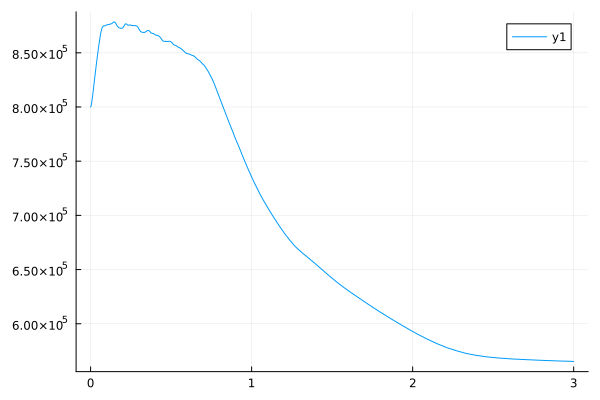

In [81]:
plot(sol1.t, sol1[airTank.p])

In [82]:
map(x -> x[1] ,sol1[transPipe12.qm])

582-element Vector{Float64}:
 10.0
  9.981547421021592
  9.800609107042096
  9.370101764848668
  8.828113691147383
  8.155106303395918
  7.348192249153714
  6.3291125572368205
  4.866286846454076
  3.909488189450508
  ⋮
 35.704638011093806
 36.79238541969035
 38.848611402209166
 40.02218086070133
 41.745660674316035
 42.76186164553814
 43.92107956213579
 44.8117193076489
 45.35063960637184

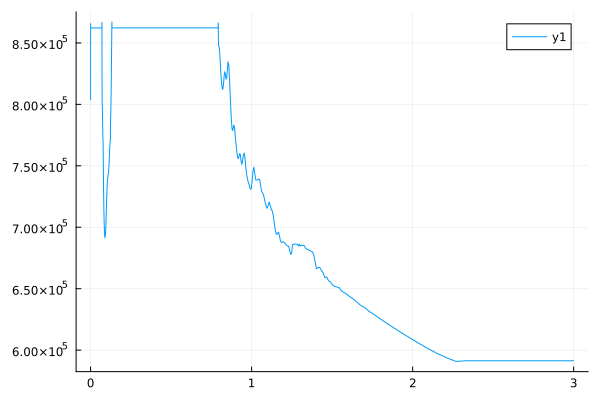

In [83]:
plot(sol1.t, map(x -> x[1] ,sol1[transPipe12.p]))

In [84]:
sol1[transPipe12.tm]

582-element Vector{Vector{Float64}}:
 [300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]
 [300.0, 300.000001, 300.000001, 300.000001, 300.000001, 300.000001, 300.000001, 300.000001, 300.000001, 300.000001, 300.000001, 300.000001, 300.000001, 300.000001, 300.000001, 300.0]
 [300.0, 300.00001100000003, 300.00001100000003, 300.00001100000003, 300.00001100000003, 300.00001100000003, 300.00001100000003, 300.00001100000003, 300.00001100000003, 300.00001100000003, 300.00001100000003, 300.00001100000003, 300.00001100000003, 300.00001100000003, 300.00001100000003, 300.0]
 [300.0, 300.00003623970485, 300.00003623970485, 300.00003623970485, 300.00003623970485, 300.00003623970485, 300.00003623970485, 300.00003623970485, 300.00003623970485, 300.00003623970485, 300.00003623970485, 300.00003623970485, 300.00003623970485, 300.00003623970485, 300.00003623970485, 300.0]
 [300.0, 300.0000709505558, 300.0000709505558, 300.0000709505558, 300.000